
# Multiclass Classification

Building a neural network to solve a multiclass classification exercise using the PyTorch framework.<br>
Classification is one of the basic machine learning exercises. A trained model aims to predict the class of an input unit with high accuracy. <br>
This neural network uses supervised learning, meaning that the input datasets also provide target labels to train the model with. <br>
<br>
This Notebook has been generated automatically using the JupyterLab extension ***MLProvCodeGen***.
<br>

Original Source Code and inspiration from this article https://janakiev.com/blog/pytorch-iris/ <br>
Original author: N. Janakiev https://github.com/njanakiev Twitter: https://twitter.com/njanakiev
        

### Installs
Install required packages before running

In [1]:
#pip install numpy===1.22.2 pandas===1.3.3 matplotlib===3.5.1 sklearn==0.0 torch===1.8.0 tqdm===4.60.0 ipywidgets===7.6.5 pytorch-model-summary===0.1.2 ipython===7.31.1 gputil===1.4.0 psutil===5.9.0 py-cpuinfo===8.0.0 --user
#torch currently not supported with python 3.10, downgrading to python 3.9.7 possibly required

### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import GPUtil
import psutil
import cpuinfo
import platform
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score, mean_absolute_error, mean_squared_error 
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import tqdm
from tqdm import trange
from datetime import date
import time
from pytorch_model_summary import hierarchical_summary
import json
import ipywidgets as widgets
import webbrowser
import IPython
from IPython.display import display

plt.style.use('ggplot')

### Provenance Data 

In [3]:
def get_size(bytes, suffix="B"):
    """
    Scale bytes to its proper format
    e.g:
        1253656 => '1.20MB'
        1253656678 => '1.17GB'
    """
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor

def set_experiment_info() :
    created_by = "Tarek Al Mustafa"
    email = "tarek.almustafa@uni-jena.de"
    title = "Multiclass Classification"
    task_type = "MulticlassClassification"
    creation_date = str(date.today())
    
    experiment_info = { 
            'author': created_by,
            'email': email,
            'title': title,
            'creation_date': creation_date,
            'task_type': task_type}
    
    return experiment_info

def set_hardware_info():
    uname = platform.uname()
    sysInfo = str(uname.system +' '+ uname.release +' Version: '+ uname.version +' Machine: '+ uname.machine)
    
    svmem = psutil.virtual_memory()

    GPUs = GPUtil.getGPUs()
    gpuList = []
    for gpu in GPUs:
        gpu_id = gpu.id
        gpu_name = gpu.name
        gpuList.append((gpu_id , gpu_name))

    hardware_info = {
        "Python Version": cpuinfo.get_cpu_info()['python_version'],
        "CPU": cpuinfo.get_cpu_info()['brand_raw'],
        "RAM": get_size(svmem.total),
        "Operating System": sysInfo,
        "GPUs": str(gpuList) }
    
    return hardware_info

def set_packages():
    cpuInfo_version = !pip list | grep -i py-cpuinfo
    pytorch_model_summary_version = !pip list | grep -i pytorch-model-summary
    packages = {
        "numpy" : np.__version__,
        "pandas" : pd.__version__,
        "matplotlib" : matplotlib.__version__,
        "sklearn" : sklearn.__version__,
        "torch" : torch.__version__,
        "tqdm" : tqdm.__version__,
        "ipywidgets" : widgets.__version__,
        "pytorch-model-summary" : pytorch_model_summary_version[0],
        "ipython" : IPython.__version__,
        "gputil" : GPUtil.__version__, 
        "psutil" : psutil.__version__,
        "py-cpuinfo" : cpuInfo_version[0]}
    
    return packages

### Data Ingestion

In [4]:
#Data Ingestion
iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
output_dim = len(names)
feature_names = iris['feature_names']

def set_data_ingestion():
    data_ingestion = {
        "dataset_id" : 'Iris',
        "output_dimensions" : output_dim,
        "samples_total" : len(X),
        "feature_dimensions" : len(feature_names) }
    
    return data_ingestion

### Data Preperation

In [5]:
#Data Preperation
# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

def set_data_preparation():
    data_preparation = {
        "number_operations" : 1,
        "transformation" : "sklearn.preprocessing.StandardScaler",
        "transformation_method" : "Standardscaler.fit_transform"}
    
    return data_preparation

### Data Segregation

In [6]:
# Data Segregation
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)

def set_data_segregation():
    data_segregation = {
        "segregation_method" : "sklearn.model_selection.train_test_split",
        "test_size" : 0.2,
        "train_size" : 1-0.2,
        "random_state" : 2 }
    
    return data_segregation

### Data Visualization

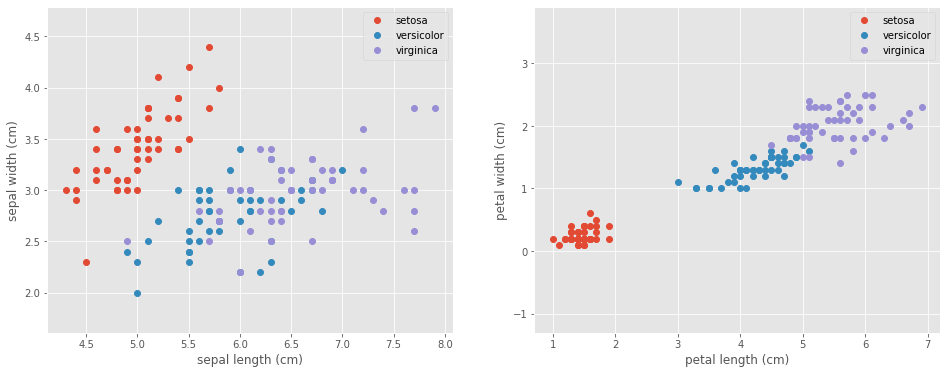

In [7]:
#Data Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    ax1.plot(X_plot[:, 0], X_plot[:, 1], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax1.set_xlabel(feature_names[0])
ax1.set_ylabel(feature_names[1])
ax1.axis('equal')
ax1.legend();

for target, target_name in enumerate(names):
    X_plot = X[y == target]
    ax2.plot(X_plot[:, 2], X_plot[:, 3], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax2.set_xlabel(feature_names[2])
ax2.set_ylabel(feature_names[3])
ax2.axis('equal')
ax2.legend();


### Model

In [8]:
#Use GPU?
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

neuron_number = 50

#Configure Neural Network Models
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 50)
        self.layer2 = nn.Linear(50, 50)
        self.layer3 = nn.Linear(50, output_dim)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x

model     = Model(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters())
loss_fn   = nn.CrossEntropyLoss()

try:
    lr
except NameError:
    default = 1
    lr = None 
else:
    default = 0

def set_model_parameters():
    model_parameters = {
        "gpu_enable" : 1,
        "modelParameters" : str(model),
        "neuron_number" : neuron_number,
        "loss_function" : 'nn.CrossEntropyLoss()',
        "optimizer" : 'torch.optim.Adam(',
        "optimizer_default_learning_rate" : default,
        "optimizer_learning_rate": lr,
        "activation_function": 'F.softmax(self.layer3(x), dim=1)' }
    return model_parameters

model

Model(
  (layer1): Linear(in_features=4, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=3, bias=True)
)

### Training

In [9]:
#Model Training
EPOCHS  = 100
X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()

loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in trange(EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

def set_training():
    training = {
    "epochs" : EPOCHS,
    "hierarchical_summary" : hierarchical_summary(model, print_summary = False) }
    
    return training

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1009.18it/s]


### Evaluation

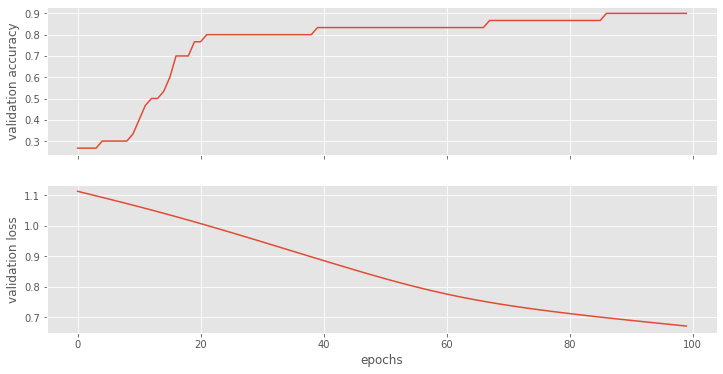

In [10]:
#Plot Accuracy and Loss from Training
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs");

def set_evaluation():
    evaluation = {
    "Accuracy": accuracy_list[(len(accuracy_list)-1)],
    "Loss": loss_list[(len(loss_list)-1)],
    "Confusion Matrix": str(confusionMatrix),
    "AUC": float(AUC),
    "F1 Score": str(F1),
    "Mean Absolute Error": MAE,
    "Mean Squared Error": MSE}
    
    return evaluation

### Confusion Matrix

In [11]:
confusionMatrix = confusion_matrix(y_test, torch.argmax(y_pred, dim=1))
confusionMatrix

array([[13,  1,  0],
       [ 0,  6,  2],
       [ 0,  0,  8]], dtype=int64)

### F1 Score

In [12]:
F1 = f1_score(y_test, torch.argmax(y_pred, dim=1), average=None)
F1

array([0.96296296, 0.8       , 0.88888889])

### Mean Absolute Error & Mean Squared Error

In [13]:
MAE = mean_absolute_error(y_test, torch.argmax(y_pred, dim=1), multioutput='uniform_average')
MSE = mean_squared_error(y_test, torch.argmax(y_pred, dim=1), multioutput='uniform_average')
print(MAE)
print(MSE)

0.1
0.1


### ROC

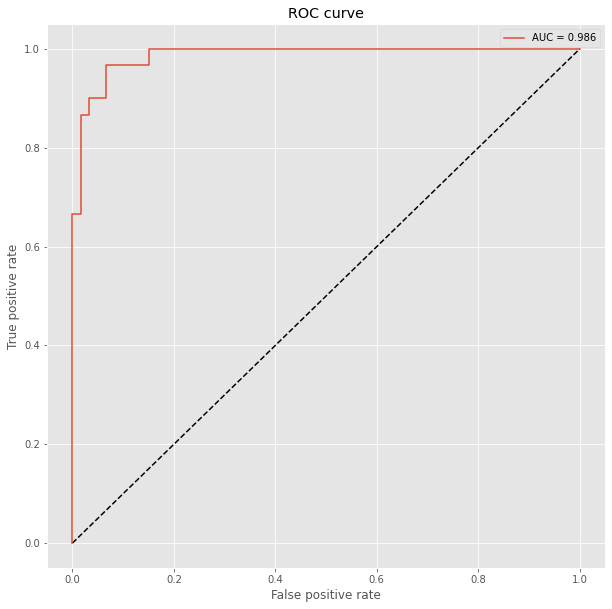

In [14]:
#ROC Curve 
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()

with torch.no_grad():
    y_pred = model(X_test).numpy()
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_pred.ravel())
    
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
AUC = '{:.5f}'.format(auc(fpr, tpr))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();

### Generate Provenance Data

In [15]:
set_experiment_info()
set_hardware_info()
set_packages()
set_data_ingestion()
set_data_preparation()
set_data_segregation()
set_model_parameters()
set_training()
set_evaluation()

{'Accuracy': 0.8999999761581421,
 'Loss': 0.6717109680175781,
 'Confusion Matrix': '[[13  1  0]\n [ 0  6  2]\n [ 0  0  8]]',
 'AUC': 0.98611,
 'F1 Score': '[0.96296296 0.8        0.88888889]',
 'Mean Absolute Error': 0.1,
 'Mean Squared Error': 0.1}

### Write Provenance Data

In [16]:
timestring = time.strftime('%Y%m%d-%H%M%S')
timestring
ProvenanceName = ('Provenance_MulticlassClassification_' + timestring + '.json')

with open('../GeneratedProvenanceData/'+ProvenanceName, 'w') as prov_file:
    prov_file.write('{' + '\n  ')
    prov_file.write('"experiment_info":' + json.dumps(set_experiment_info(),sort_keys=False, indent=4) +',' + '\n\n' )
    prov_file.write('"hardware_info":' + json.dumps(set_hardware_info(),sort_keys=False, indent=4) +',' + '\n\n' )
    prov_file.write('"packages":' + json.dumps(set_packages(),sort_keys=False, indent=4) +',' + '\n\n' )
    prov_file.write('"data_ingestion":' + json.dumps(set_data_ingestion(),sort_keys=False, indent=4) +',' + '\n\n' )
    prov_file.write('"data_preparation":' + json.dumps(set_data_preparation(),sort_keys=False, indent=4) +',' + '\n\n' )
    prov_file.write('"data_segregation":' + json.dumps(set_data_segregation(),sort_keys=False, indent=4) +',' + '\n\n' )
    prov_file.write('"model_parameters":' + json.dumps(set_model_parameters(),sort_keys=False, indent=4) +',' + '\n\n' )
    prov_file.write('"training":' + json.dumps(set_training(),sort_keys=False, indent=4) +',' + '\n\n' )
    prov_file.write('"evaluation":' + json.dumps(set_evaluation(),sort_keys=False, indent=4) + '\n' )
    prov_file.write('}')

### Show Provenance Data

In [17]:
provenance_open = widgets.Button(description = 'Open Provenance Data File')
display(provenance_open)

def on_button_clicked(b):
    provenance_open.on_click = webbrowser.open('http://localhost:8888/lab/tree/GeneratedProvenanceData/'+ProvenanceName)

provenance_open.on_click(on_button_clicked)

Button(description='Open Provenance Data File', style=ButtonStyle())